In [1]:
# Libraries
from pandas import DataFrame, read_csv, concat
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from matplotlib import pyplot as plt
from numpy import concatenate, reshape
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sys import argv
import csv
import datetime
import time

In [2]:
# Series to Supervised Learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    # print("I: ",i)
        cols.append(df.shift(i))
        # print("Column: ",cols)
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # print("Names: ",names)
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        # print("COls: ",cols)
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # print("Names: ",names)

    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg

In [3]:
# Read Data and Extract Values
# Read Data and Extract Values



fileName = 'BTC Dataset (with Sentiment).csv'
dataset = read_csv(fileName, parse_dates=['timestamp']) 


startIndex = 3
nrows = dataset.shape[0]
values = dataset.iloc[:,startIndex:].values #Getting values - Total Sentiment and BTC Values
valuesCrypto = dataset.iloc[:,-1:].values #Getting values -  C Values
# For predicting with just Cryptocurrency values, we have just 1 input variable. 
# Incorporating sentiment values will make input variables=2

# Comment the below line if there are multiple features / input variable.
# values = values.reshape(-1,1) #Only do this if you have 1 input variable

In [4]:
# Scaling
scaler = MinMaxScaler(feature_range = (0,1))
scaler = scaler.fit(values)
scaled = scaler.fit_transform(values)

In [5]:
# Input and Output Sequence Length
input_sequence = 1
output_sequence = 1


# Call Series to Supervised Function
reframed = series_to_supervised(scaled, input_sequence, output_sequence)


In [6]:
# Drop current sentiment/any other feature that might be added in the future(at time t)
dropColumns = []
for i in range(values.shape[1]-1):
    dropColumns.append('var{}(t)'.format(i+1))
reframed=reframed.drop(columns=dropColumns)

# Drop cuurent sentiment
# reframed=reframed.drop(columns=['var1(t)'])


In [7]:
# Ignore the headers
reframedValues = reframed.values

#Splitting data into train and test sets

n_train_days = int(0.9*nrows) #90% data is train, 10% test
train = reframedValues[:n_train_days, :]
test = reframedValues[n_train_days:nrows, :]

#Assigning inputs and output datasets
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

#Reshaping input to be 3 dimensions (samples, timesteps, features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [8]:
#Building LSTM Neural Network model
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]))) #Recurrent Layer

model.add(Dropout(0.4)) #Dropout Layer
model.add(Dense(15, activation = 'tanh')) #Fully Connected Layer
model.add(Dense(1)) #Output Layer
model.compile(loss='mae', optimizer= 'adam', metrics=['acc']) #Compiling the model

# Uncomment below line to get summary of the model
# print(model.summary(line_length=None, positions=None, print_fn=None))


#Fitting model
history = model.fit(train_X, train_y, epochs = 200, batch_size=25, validation_data=(test_X, test_y), verbose=2, shuffle=False) #Best so far: 100 neurons, epochs = 400, batch_size = 53
print(history.history)

Epoch 1/200
87/87 - 1s - loss: 0.0555 - acc: 4.6339e-04 - val_loss: 0.1165 - val_acc: 0.0042
Epoch 2/200
87/87 - 0s - loss: 0.1129 - acc: 4.6339e-04 - val_loss: 0.0751 - val_acc: 0.0042
Epoch 3/200
87/87 - 0s - loss: 0.0799 - acc: 4.6339e-04 - val_loss: 0.0471 - val_acc: 0.0042
Epoch 4/200
87/87 - 0s - loss: 0.0435 - acc: 4.6339e-04 - val_loss: 0.0391 - val_acc: 0.0042
Epoch 5/200
87/87 - 0s - loss: 0.0354 - acc: 4.6339e-04 - val_loss: 0.0449 - val_acc: 0.0042
Epoch 6/200
87/87 - 0s - loss: 0.0294 - acc: 4.6339e-04 - val_loss: 0.0553 - val_acc: 0.0042
Epoch 7/200
87/87 - 0s - loss: 0.0236 - acc: 4.6339e-04 - val_loss: 0.0471 - val_acc: 0.0042
Epoch 8/200
87/87 - 0s - loss: 0.0207 - acc: 4.6339e-04 - val_loss: 0.0142 - val_acc: 0.0042
Epoch 9/200
87/87 - 0s - loss: 0.0185 - acc: 4.6339e-04 - val_loss: 0.0161 - val_acc: 0.0042
Epoch 10/200
87/87 - 0s - loss: 0.0127 - acc: 4.6339e-04 - val_loss: 0.0157 - val_acc: 0.0042
Epoch 11/200
87/87 - 0s - loss: 0.0163 - acc: 4.6339e-04 - val_loss: 

Epoch 89/200
87/87 - 0s - loss: 0.0142 - acc: 4.6339e-04 - val_loss: 0.0239 - val_acc: 0.0042
Epoch 90/200
87/87 - 0s - loss: 0.0107 - acc: 4.6339e-04 - val_loss: 0.0144 - val_acc: 0.0042
Epoch 91/200
87/87 - 0s - loss: 0.0111 - acc: 4.6339e-04 - val_loss: 0.0157 - val_acc: 0.0042
Epoch 92/200
87/87 - 0s - loss: 0.0102 - acc: 4.6339e-04 - val_loss: 0.0159 - val_acc: 0.0042
Epoch 93/200
87/87 - 0s - loss: 0.0126 - acc: 4.6339e-04 - val_loss: 0.0145 - val_acc: 0.0042
Epoch 94/200
87/87 - 0s - loss: 0.0102 - acc: 4.6339e-04 - val_loss: 0.0337 - val_acc: 0.0042
Epoch 95/200
87/87 - 0s - loss: 0.0148 - acc: 4.6339e-04 - val_loss: 0.0344 - val_acc: 0.0042
Epoch 96/200
87/87 - 0s - loss: 0.0102 - acc: 4.6339e-04 - val_loss: 0.0162 - val_acc: 0.0042
Epoch 97/200
87/87 - 0s - loss: 0.0112 - acc: 4.6339e-04 - val_loss: 0.0144 - val_acc: 0.0042
Epoch 98/200
87/87 - 0s - loss: 0.0199 - acc: 4.6339e-04 - val_loss: 0.0140 - val_acc: 0.0042
Epoch 99/200
87/87 - 0s - loss: 0.0130 - acc: 4.6339e-04 - v

Epoch 176/200
87/87 - 0s - loss: 0.0107 - acc: 4.6339e-04 - val_loss: 0.0186 - val_acc: 0.0042
Epoch 177/200
87/87 - 0s - loss: 0.0123 - acc: 4.6339e-04 - val_loss: 0.0321 - val_acc: 0.0042
Epoch 178/200
87/87 - 0s - loss: 0.0171 - acc: 4.6339e-04 - val_loss: 0.0258 - val_acc: 0.0042
Epoch 179/200
87/87 - 0s - loss: 0.0117 - acc: 4.6339e-04 - val_loss: 0.0225 - val_acc: 0.0042
Epoch 180/200
87/87 - 0s - loss: 0.0097 - acc: 4.6339e-04 - val_loss: 0.0272 - val_acc: 0.0042
Epoch 181/200
87/87 - 0s - loss: 0.0117 - acc: 4.6339e-04 - val_loss: 0.0321 - val_acc: 0.0042
Epoch 182/200
87/87 - 0s - loss: 0.0104 - acc: 4.6339e-04 - val_loss: 0.0267 - val_acc: 0.0042
Epoch 183/200
87/87 - 0s - loss: 0.0108 - acc: 4.6339e-04 - val_loss: 0.0421 - val_acc: 0.0042
Epoch 184/200
87/87 - 0s - loss: 0.0117 - acc: 4.6339e-04 - val_loss: 0.0266 - val_acc: 0.0042
Epoch 185/200
87/87 - 0s - loss: 0.0105 - acc: 4.6339e-04 - val_loss: 0.0248 - val_acc: 0.0042
Epoch 186/200
87/87 - 0s - loss: 0.0100 - acc: 4.6

In [9]:
# Predicition
model_prediction = model.predict(test_X)

In [12]:
# Inverse Scale
scalerCrypto = MinMaxScaler(feature_range = (0,1))
scalerCrypto = scaler.fit(valuesCrypto)
scaledCrypto = scaler.fit_transform(valuesCrypto)

model_prediction_unscale = scalerCrypto.inverse_transform(model_prediction)
predictedValues = reshape(model_prediction_unscale, model_prediction_unscale.shape[0])
actualValues = valuesCrypto[n_train_days+input_sequence:] #test_y+input_sequence:
actualValues = reshape(actualValues, actualValues.shape[0])


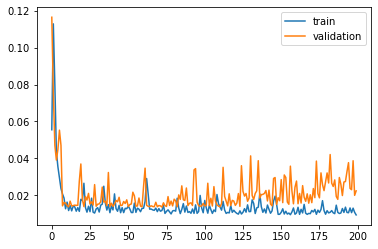

In [13]:
#Plotting training loss vs validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

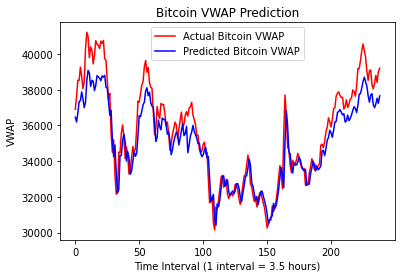

In [14]:
#Visualising Results (Actual vs Predicted)
plt.plot(actualValues, color = 'red', label = 'Actual Bitcoin VWAP')
plt.plot(predictedValues, color = 'blue', label = 'Predicted Bitcoin VWAP') #[1:38]
plt.title('Bitcoin VWAP Prediction')
plt.xlabel('Time Interval (1 interval = 3.5 hours)')
plt.ylabel('VWAP')
plt.legend()

# Uncomment below line to save the figure
# plt.savefig('Trend Graph.png', dpi=700)

plt.show()

In [15]:
actual= DataFrame(actualValues, columns= ['Actual Value'])
predicted=DataFrame(predictedValues, columns= ['Predicted Value'])

In [16]:
#Calculating RMSE and MAE
errorDF=concat([actual,predicted], axis=1)
errorDF.dropna(inplace=True)
rmse = sqrt(mean_squared_error(errorDF.iloc[:,0], errorDF.iloc[:,1]))
mae = mean_absolute_error(errorDF.iloc[:,0], errorDF.iloc[:,1])
print('Test MAE: %.3f' % mae)
print('Test RMSE: %.3f' % rmse)

Test MAE: 819.268
Test RMSE: 1039.681


In [17]:
# Write to csv
writeFileName = "Results - withSentiment.csv"
timestamp = DataFrame(dataset['timestamp'][n_train_days+1:], columns= ['timestamp'])
timestamp.reset_index(drop=True, inplace=True)
results=concat([timestamp,actual,predicted], axis=1)
print("Head: ",results.head())
print("Tail: ",results.tail())
results.dropna(inplace=True)
results.to_csv(writeFileName, index= False)

Head:              timestamp  Actual Value  Predicted Value
0 2021-01-07 06:15:00   36897.02667     36458.058594
1 2021-01-07 09:30:00   37653.01000     36190.125000
2 2021-01-07 12:45:00   38532.68667     36689.171875
3 2021-01-07 16:00:00   38523.09667     37331.257812
4 2021-01-07 19:15:00   39265.89000     37391.054688
Tail:                timestamp  Actual Value  Predicted Value
234 2021-02-07 22:45:00      38346.86     36990.593750
235 2021-02-08 02:00:00      38801.59     37197.164062
236 2021-02-08 05:15:00      38410.30     37522.843750
237 2021-02-08 08:30:00      39001.60     37237.777344
238 2021-02-08 11:45:00      39201.49     37652.234375


In [37]:
# Analyzer 2
with open(writeFileName, newline='') as read_file:

    results = csv.reader(read_file, delimiter=',', quotechar='|')
    next(results)

    time = []
    actual = []
    predicted = []
    n_percent= 2

    # Pull data from CSV and store in arrays.
    for row in results:
        # print(row)
        time.append(row[0])
        actual.append(float(row[1]))
        predicted.append(float(row[2]))

    actual_delta = []
    predicted_delta = []
    correct_long = 0
    incorrect_long = 0
    correct_short = 0
    incorrect_short = 0

    profit = []
    profit_agg = 0

    # Process predictions, print analytics.
    for i in range(2, len(actual) - 1):
        a_delta = (actual[i + 1] - actual[i]) / actual[i + 1]
        p_delta = (predicted[i + 1] - predicted[i]) / predicted[i + 1]
#         print("time_start", time[i])
#         print("time_ended", time[i+1])
#         print("actual_price", actual[i], "->", actual[i+1])
#         print("actual_delta", a_delta * 100)
#         print("predicted_price", predicted[i], "->", predicted[i + 1])
#         print("predicted_delta", p_delta * 100)
#         print("difference", abs(a_delta - p_delta) * 100)

        if p_delta > 0 and a_delta > 0 and abs(a_delta)*100>n_percent:
            correct_long += 1
            profits = 10000 * abs(a_delta)
            profit.append(profits)
            profit_agg += profits
            #print('gain/loss', profits)

        if p_delta > 0 > a_delta and abs(a_delta)*100>n_percent:
            incorrect_long += 1
            profits = -10000 * abs(a_delta)
            profit.append(profits)
            profit_agg += profits
            #print('gain/loss', profits)

        # To ignore the "short" predictions, comment out the following 2 if-blocks.

        if p_delta < 0 and a_delta < 0 and abs(a_delta)*100>n_percent:
            correct_short += 1
            profits = 10000 * abs(a_delta)
            profit.append(profits)
            profit_agg += profits
            #print('gain/loss', profits)

        if p_delta < 0 < a_delta and abs(a_delta)*100>n_percent:
            incorrect_short += 1
            profits = -10000 * abs(a_delta)
            profit.append(profits)
            profit_agg += profits
            #print('gain/loss', profits)

#         print()
    print('Analyzer 2 ')
    print("------------")
    print('correct_long', correct_long)
    print('incorrect_long', incorrect_long)
    print('correct_short', correct_short)
    print('incorrect_short', incorrect_short)
    print('profit_tracker', profit_agg)

Analyzer 2 
------------
correct_long 17
incorrect_long 13
correct_short 18
incorrect_short 5
profit_tracker 4685.835869461013
